<a href="https://colab.research.google.com/github/HudaZainElAbden/Sentence-to-Sentence-semantic-similarity-NLP/blob/main/Sentence_To_Sentence_Semantic_similarity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import  seaborn as sns
import matplotlib.pyplot as plt
!pip install gensim
import gensim
import gensim.downloader as api
from scipy import spatial
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load data set and print head

In [ ]:
data = pd.read_csv("train.csv")

print("Number of data points:",data.shape[0])
data.head()

Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


display info of data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Visualization of data set**

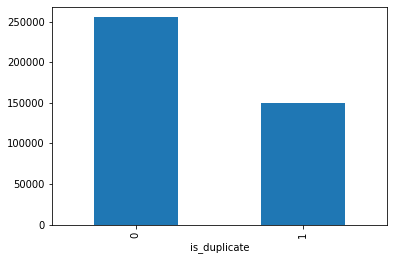

In [ ]:
data.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
qs_series = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
num_Unique_qs = len(np.unique(qs_series))
qs_appear_morethan_onetime = np.sum(qs_series.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(num_Unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_appear_morethan_onetime,qs_appear_morethan_onetime/num_Unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qs_series.value_counts()))) 

q_vals=qs_series.value_counts()

q_vals=q_vals.values


Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


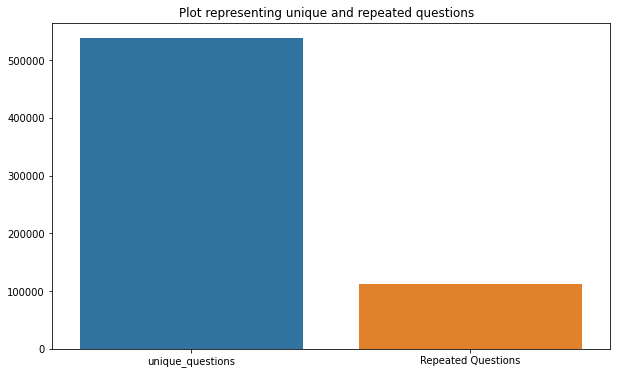

In [ ]:
a = ["unique_questions" , "Repeated Questions"]
b =  [num_Unique_qs , qs_appear_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(a,b)
plt.show()

**Preprocessing**

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
0


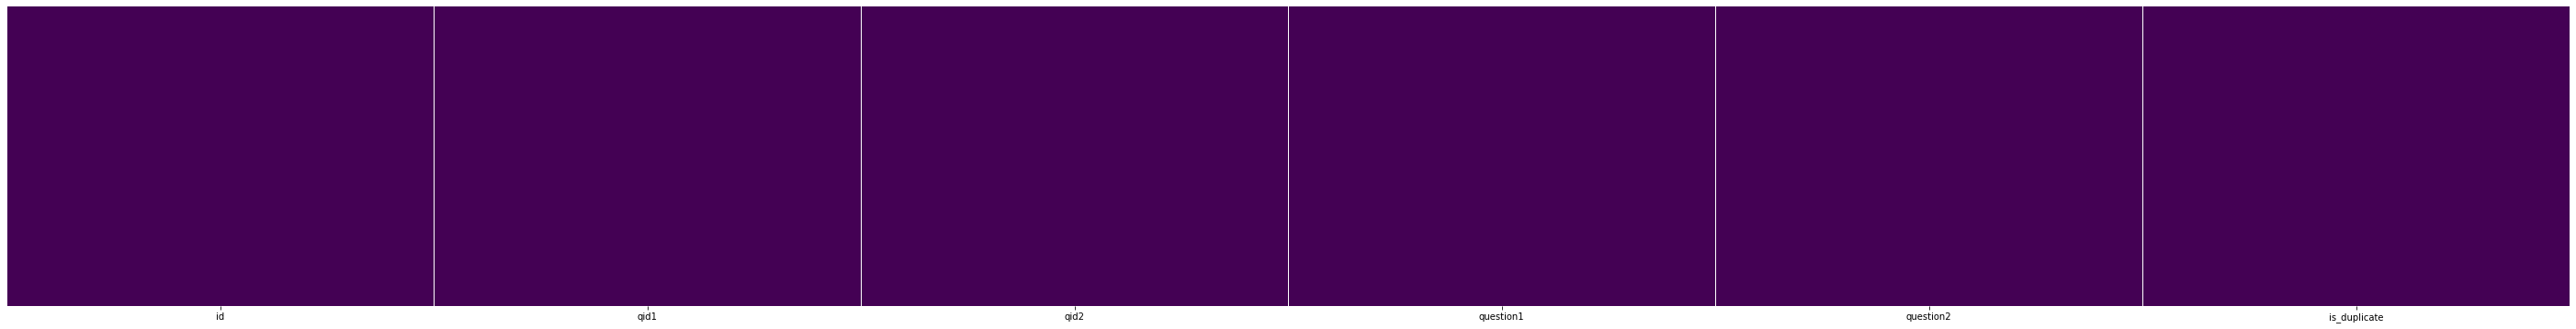

In [ ]:
#check nulls
data['question1'].fillna("", inplace = True)
data['question2'].fillna("", inplace = True)
print(data.isnull().sum())
print(data.isnull().values.sum())
f, ax = plt.subplots(figsize=(50, 6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap="viridis",ax=ax)

In [ ]:
def replace_abbreviation(sentence):
  sentence = re.sub(r"1st", "first", sentence)
  sentence = re.sub(r"2nd", "second", sentence)
  sentence = re.sub(r"3rd", "third", sentence)
  # sentence = re.sub(r'([0-9]+)k ', r'\1000 ', sentence)
  # sentence = re.sub(r'([0-9]+)m ', r'\1000000 ', sentence)
  # sentence = re.sub(r'([0-9]+)b ', r'\1000000000 ', sentence)
  sentence = re.sub(r'([0-9]+)y ', r'\1 years ', sentence)
  sentence = re.sub(r'([0-9]+)s ', r'\1 seconds ', sentence)
  sentence = re.sub(r"what's", "", sentence)
  sentence = re.sub(r"\'s", " ", sentence)
  sentence = re.sub(r"\'ve", " have ", sentence)
  sentence = re.sub(r"can't", "can not ", sentence)
  sentence = re.sub(r"n't", " not ", sentence)
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r" m ", " am ", sentence)
  sentence = re.sub(r"\'re", " are ", sentence)
  sentence = re.sub(r"\'d", " would ", sentence)
  sentence = re.sub(r"\'ll", " will ", sentence)
  sentence = re.sub(r" e g ", " eg ", sentence)
  sentence = re.sub(r" b g ", " bg ", sentence)
  sentence = re.sub(r"\0s", "0", sentence)
  sentence = re.sub(r" 9 11 ", "911", sentence)
  sentence = re.sub(r"e-mail", "email", sentence)
  sentence = re.sub(r"\s{2,}", " ", sentence)
  sentence = re.sub(r"quikly", "quickly", sentence)
  sentence = re.sub(r" usa ", " america ", sentence)
  sentence = re.sub(r" u s ", " america ", sentence)
  sentence = re.sub(r" uk ", " england ", sentence)
  sentence = re.sub(r"imrovement", "improvement", sentence)
  sentence = re.sub(r"intially", "initially", sentence)
  sentence = re.sub(r" dms ", "direct messages ", sentence)  
  sentence = re.sub(r"demonitization", "demonetization", sentence) 
  sentence = re.sub(r"actived", "active", sentence)
  sentence = re.sub(r"kms", " kilometers ", sentence)
  sentence = re.sub(r" cs ", " computer science ", sentence) 
  sentence = re.sub(r" upvotes ", " up votes ", sentence)
  sentence = re.sub(r" iphone ", " phone ", sentence)
  sentence = re.sub(r"\0rs ", " rs ", sentence) 
  sentence = re.sub(r"calender", "calendar", sentence)
  sentence = re.sub(r"ios", "operating system", sentence)
  sentence = re.sub(r"programing", "programming", sentence)
  sentence = re.sub(r"bestfriend", "best friend", sentence)
  sentence = re.sub(r"iii", "3", sentence) 
  sentence = re.sub(r"the us", "america", sentence)
  sentence = re.sub(r" j k ", " jk ", sentence)
  sentence = re.sub(r"[^A-Za-z0-9]", " ", sentence)

  return sentence

In [ ]:
def sentence_preprocess(sentence):
  
  # Change sentence to lowercase
  sentence = sentence.lower()
  # Replace abbreviations with its original 
  sentence = replace_abbreviation(sentence)

  # # Remove punctuation
  # for c in sentence:
  #   if c in punctuation:
  #     sentence = sentence.replace(c, " ")
  
  # Tokenization
  tokens = word_tokenize(sentence)

  # Remove stop words
  stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
  for token in list(tokens):
    if token in stop_words:
      tokens.remove(token)
  # Snowball stemmer
  lemmatizer=WordNetLemmatizer()


  stemmer = SnowballStemmer('english')
  tokens = [lemmatizer.lemmatize(token) for token in list(tokens)]

  sentence = ""
  for token in list(tokens):
    sentence += token
    sentence += " "
  return sentence

In [ ]:
for i in range(404290):
  data['question1'][i] = sentence_preprocess(data['question1'][i])
  data['question2'][i] = sentence_preprocess(data['question2'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
preprocessed_data = pd.DataFrame(data)
preprocessed_data.to_csv('preprocessed Data.csv', index = False)

In [ ]:
preprocessed_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step by step guide invest in share market in i...,step by step guide invest in share market,0
1,1,3,4,story kohinoor koh i noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,how can i increase speed my internet connectio...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find remainder when math 23 24 math divided by...,0
4,4,9,10,one dissolve in water quickly sugar salt metha...,fish would survive in salt water,0


Feature extraction after preprocessing

In [ ]:
new_data=pd.read_csv("preprocessed Data.csv")
new_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step by step guide invest in share market in i...,step by step guide invest in share market,0
1,1,3,4,story kohinoor koh i noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,how can i increase speed my internet connectio...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find remainder when math 23 24 math divided by...,0
4,4,9,10,one dissolve in water quickly sugar salt metha...,fish would survive in salt water,0


In [ ]:
new_data.fillna(" ", inplace = True)
print(new_data.isnull().values.sum())

0


In [ ]:
#get unique qids after preprocessing
qids = pd.Series(new_data['qid1'].tolist() + new_data['qid2'].to_list())
len_unique_qs = len(np.unique(qids))
unique_qs=np.unique(qids)
len_unique_qs

537933

In [ ]:
#get unique id with its questions
q1=new_data.drop(["qid2","id","is_duplicate","question2"],axis=1)
q1.drop_duplicates(inplace=True)
q1.rename(columns = {'qid1':'id','question1':'sentence'}, inplace = True)

q2=new_data.drop(["qid1","id","is_duplicate","question1"],axis=1)
q2.drop_duplicates(inplace=True)
q2.rename(columns = {'qid2':'id','question2':'sentence'}, inplace = True)

questions=q1.append(q2)
questions.drop_duplicates(inplace=True)
questions.head()

,id,sentence
0,1,step by step guide invest in share market in i...
1,3,story kohinoor koh i noor diamond
2,5,how can i increase speed my internet connectio...
3,7,why am i mentally very lonely how can i solve it
4,9,one dissolve in water quickly sugar salt metha...


In [ ]:
#toknize unique questions to use it in model
list_of_sentences=questions['sentence'].tolist()
tags=questions["id"].tolist()
list_of_toknized=[]

for i,item in enumerate(list_of_sentences):   
     list_of_toknized.append(list((word_tokenize(item))))

**Use Doc2vec model to get similarity vector for each quetions**


* Note:doc2vec work like word2vec but it take sentences or paragraph instead of words




In [ ]:
def tagged_document(list_of_list_of_words,IDs):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [IDs[i]])
      
data_for_training = list(tagged_document(list_of_toknized,tags))      

In [ ]:
print(data_for_training[:1])

[TaggedDocument(words=['step', 'by', 'step', 'guide', 'invest', 'in', 'share', 'market', 'in', 'india'], tags=[1])]


In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=60, min_count=1,epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
model.docvecs[1]

C:\Users\Home\AppData\Local\Temp\ipykernel_9168\976694921.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs[1]


array([ 0.07896803,  0.18069178,  0.3792438 ,  0.07841805, -0.39544594,
       -0.2632719 ,  0.00163435,  0.23615171, -0.1349007 ,  0.4297897 ,
        0.14795719,  0.20966345,  0.03437318,  0.24117179,  0.1036299 ,
       -0.21856555, -0.2235318 ,  0.17934714, -0.06846726, -0.1586102 ,
        0.10167263,  0.1050813 ,  0.4624268 ,  0.13432328,  0.22248732,
       -0.14885983,  0.04906604, -0.16424249, -0.28539926, -0.1300657 ,
        0.07496606, -0.32094488,  0.21149059,  0.0807754 ,  0.07699236,
        0.06865352,  0.16819929, -0.32320386, -0.11470935, -0.05469933,
        0.23345977,  0.08360439, -0.37206566, -0.02951398, -0.35933644,
       -0.26181346, -0.24260317,  0.04034615, -0.03042798,  0.33221734,
       -0.30698875,  0.11991305, -0.04144036,  0.24557762,  0.19196388,
        0.21885742,  0.02858871, -0.1885479 ,  0.27205813,  0.07080574],
      dtype=float32)

In [ ]:
cosine_similarity=[]
def get_cosine_similarity(row):
    #print(row["qid1"])
    sentence1_vec=model.docvecs[row["qid1"]]
    sentence2_vec=model.docvecs[row["qid2"]]
    return 1 - spatial.distance.cosine(sentence1_vec, sentence2_vec)

In [ ]:
new_data["cosine_similarity"]=new_data.apply(get_cosine_similarity,axis=1)

C:\Users\Home\AppData\Local\Temp\ipykernel_9168\2670672972.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  sentence1_vec=model.docvecs[row["qid1"]]
C:\Users\Home\AppData\Local\Temp\ipykernel_9168\2670672972.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  sentence2_vec=model.docvecs[row["qid2"]]


In [ ]:
def common_words_ratio(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    m=len(w1)+len(w2)    
    return (len(w1 & w2))/m

In [ ]:
new_data["word_share"]=new_data.apply(common_words_ratio,axis=1)

In [ ]:

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 
 
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[1] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
   
    # Last word of both question is same or not
    token_features[2] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[3] = int(q1_tokens[0] == q2_tokens[0])

    
    

    return token_features

In [ ]:
token_features = new_data.apply(fetch_token_features, axis=1)

new_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_data["last_word_eq"]  = list(map(lambda x: x[2], token_features))
new_data["first_word_eq"] = list(map(lambda x: x[3], token_features))


In [ ]:
new_data['q1_freq']=new_data.groupby('qid1')['qid1'].transform('count')
new_data['q2_freq']=new_data.groupby('qid2')['qid2'].transform('count')

In [ ]:
new_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,cosine_similarity,word_share,cwc_min,cwc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,word_common,word_total,q1_freq,q2_freq
0,0,1,2,step by step guide invest in share market in i...,step by step guide invest in share market,0,0.961292,0.470588,0.874989,0.699993,0.0,1.0,2.0,9.0,7.0,18.0,1,1
1,1,3,4,story kohinoor koh i noor diamond,would happen indian government stole kohinoor ...,0,0.504665,0.315789,0.833319,0.454541,0.0,0.0,5.0,8.5,5.0,17.0,4,1
2,2,5,6,how can i increase speed my internet connectio...,how can internet speed be increased by hacking...,0,0.305122,0.238095,0.444440,0.399996,0.0,1.0,1.0,9.5,4.0,19.0,1,1
3,3,7,8,why am i mentally very lonely how can i solve it,find remainder when math 23 24 math divided by...,0,0.446903,0.050000,0.000000,0.000000,0.0,0.0,0.0,11.0,0.0,22.0,1,1
4,4,9,10,one dissolve in water quickly sugar salt metha...,fish would survive in salt water,0,0.378238,0.210526,0.499992,0.272725,0.0,0.0,5.0,8.5,3.0,17.0,3,1
5,5,11,12,astrology i am capricorn sun cap moon cap risi...,i am triple capricorn sun moon ascendant in ca...,1,0.770365,0.375000,0.666661,0.666661,1.0,0.0,0.0,12.0,8.0,24.0,1,1
6,6,13,14,should i buy tiago,keep childern active far from phone video game,0,0.414605,0.071429,0.000000,0.000000,0.0,0.0,4.0,6.0,0.0,12.0,1,1
7,7,15,16,how can i be good geologist,should i do be great geologist,1,0.759090,0.285714,0.499992,0.499992,1.0,0.0,0.0,6.0,3.0,12.0,1,1
8,8,17,18,when do you use instead,when do you use instead,0,0.962969,0.500000,0.999980,0.999980,1.0,1.0,0.0,5.0,5.0,10.0,1,2
9,9,19,20,motorola company can i hack my charter motorol...,how do i hack motorola dcx3400 free internet,0,0.337060,0.263158,0.499994,0.444440,0.0,0.0,1.0,8.5,4.0,17.0,1,1


split data into 80% train & 20 % test

In [ ]:
X=MinMaxScaler().fit_transform(new_data[['cosine_similarity','cwc_min','cwc_max','last_word_eq','first_word_eq','word_share','q1_freq','q2_freq']])#features
Y=new_data["is_duplicate"].values#label

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True,random_state=10)
print(X.shape)
print(Y.shape)


(404290, 8)
(404290,)


In [ ]:
def train_model(X_train, X_test, y_train, y_test, model):
    # fit the training dataset on the classifier
    model.fit(X_train, y_train)
    # predict the labels on validation dataset
    y_train_predicted = model.predict(X_train)
    prediction = model.predict(X_test)

    train_err = metrics.accuracy_score(y_train, y_train_predicted)
    test_err = metrics.accuracy_score(y_test, prediction)
    
    print('Train subset accuracy ', train_err)
    print('Test subset accuracy' ,test_err)
    cm=metrics.confusion_matrix(y_test, prediction)
    return cm

In [ ]:
#adaboost classifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm="SAMME",n_estimators=300)
bdt_graph=train_model(X_train, X_test, y_train, y_test, bdt)

Train subset accuracy  0.8009627989809295
Test subset accuracy 0.8003413391377476


In [ ]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3,n_estimators=300)
rf_graph=train_model(X_train, X_test, y_train, y_test, rf)

Train subset accuracy  0.7704123277845111
Test subset accuracy 0.7712533082688169


In [ ]:
#XGBClassifier
#%pip install --default-timeout=100 xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_graph=train_model(X_train, X_test, y_train, y_test, xgb)

Train subset accuracy  0.8166322441811571
Test subset accuracy 0.8105444111899874


<AxesSubplot:>

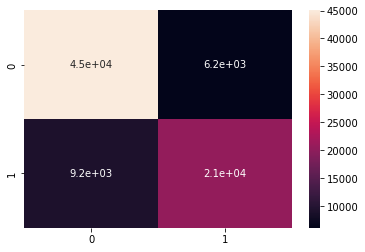

In [ ]:
sns.heatmap(xgb_graph,annot=True)